# Volatility smile

Volatility smiles are implied volatility patterns that arise in pricing financial options.  It corresponds to finding one single parameter (implied volatility) that is needed to be modified for the Black-Scholes formula to fit market prices. Graphing implied volatilities against strike prices for a given expiry yields a skewed "smile" instead of the expected flat surface.



Next, we shall demonstrate volatility smiles by computing implied volatility to multiple market option prices. For instance, we can fix the maturity, and compute volatilities for different strikes. If we plot a strike versus vol figure , we shall see the smily face there.



- copy/paste/upload data from [here](https://github.com/songqsh/20s_ma573/blob/master/src/20optiondata2.dat)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as so
import scipy.stats as ss

- Read data from .dat file. It has call option prices of 
  - maturities 2 months and 5 months;
  - strikes of 97, 99, 101, 103

In [2]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price
np_option_data1 = np.loadtxt('20optiondata2.dat', comments='#', delimiter=',')

print('>>>>>>otype, maturity, strike, option_price')
print(np_option_data1)

>>>>>>otype, maturity, strike, option_price
[[  1.           0.16666667  97.           5.32705461]
 [  1.           0.16666667  99.           3.86224255]
 [  1.           0.16666667 101.           2.7204371 ]
 [  1.           0.16666667 103.           2.1202793 ]
 [  1.           0.41666667  97.           7.23756307]
 [  1.           0.41666667  99.           5.95053461]
 [  1.           0.41666667 101.           5.2640122 ]
 [  1.           0.41666667 103.           4.97493422]]


In [0]:
'''=========
option class init
=========='''
class VanillaOption:
    def __init__(
        self,
        otype = 1, # 1: 'call'
                  # -1: 'put'
        strike = 110.,
        maturity = 1.,
        market_price = 10.):
      self.otype = otype
      self.strike = strike
      self.maturity = maturity
      self.market_price = market_price #this will be used for calibration
      
        
    def payoff(self, s): #s: excercise price
      otype = self.otype
      k = self.strike
      maturity = self.maturity
      return max([0, (s - k)*otype])
'''============
Gbm class
============='''

class Gbm:
    def __init__(self,
                 init_state = 100.,
                 drift_ratio = .0475,
                 vol_ratio = .2
                ):
        self.init_state = init_state
        self.drift_ratio = drift_ratio
        self.vol_ratio = vol_ratio

'''========
Black-Scholes-Merton formula. 
=========='''

def bsm_price(self, vanilla_option):
    s0 = self.init_state
    sigma = self.vol_ratio
    r = self.drift_ratio
    
    otype = vanilla_option.otype
    k = vanilla_option.strike
    maturity = vanilla_option.maturity
    
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma ** 2) 
          * maturity) / (sigma * np.sqrt(maturity))
    d2 = d1 - sigma * np.sqrt(maturity)
    
    return (otype * s0 * ss.norm.cdf(otype * d1) #line break needs parenthesis
            - otype * np.exp(-r * maturity) * k * ss.norm.cdf(otype * d2))

Gbm.bsm_price = bsm_price

In [0]:
'''================
define an error function
===================='''
def error_function(vol, gbm, option):
  gbm.vol_ratio = vol
  return abs(option.market_price - gbm.bsm_price(option))

  
'''==========
define a method to seek for an implied volatility
============'''
import scipy.optimize as so
def implied_volatility(gbm, option):
  init_vol = .1 #initial guess
  return so.fmin(error_function, init_vol, 
                 args = (gbm, option), disp = 0)[0]

In [0]:
'''==============
below defines for underlying process
================='''
gbm1 = Gbm(
    init_state = 100., #market data
    drift_ratio = .05, #market data
    vol_ratio = .1 #initial guess
)

In [0]:
'''====================
create option_list from the data
======================='''

num_row = np_option_data1.shape[0]
option_list = []

for i in range(num_row):
  option1 = VanillaOption(
      otype = np_option_data1[i,0],
      strike = np_option_data1[i,2],
      maturity = np_option_data1[i,1],
      market_price = np_option_data1[i,3]
  )   
  option_list.append(option1)

In [7]:
#expand one column for vol
np_option_data2 = np.append(np_option_data1, np.zeros([num_row,1]), axis = 1)
#compute implied vols and add them into the last column
for i in range(num_row):
  np_option_data2[i,4] = implied_volatility(gbm1, option_list[i])
  
print('>>>>>>otype, maturity, strike, option_price, implied vol')
print(np_option_data2)  

>>>>>>otype, maturity, strike, option_price, implied vol
[[  1.           0.16666667  97.           5.32705461   0.19125   ]
 [  1.           0.16666667  99.           3.86224255   0.17724609]
 [  1.           0.16666667 101.           2.7204371    0.17183594]
 [  1.           0.16666667 103.           2.1202793    0.18681641]
 [  1.           0.41666667  97.           7.23756307   0.170625  ]
 [  1.           0.41666667  99.           5.95053461   0.16804688]
 [  1.           0.41666667 101.           5.2640122    0.18373047]
 [  1.           0.41666667 103.           4.97493422   0.20901367]]


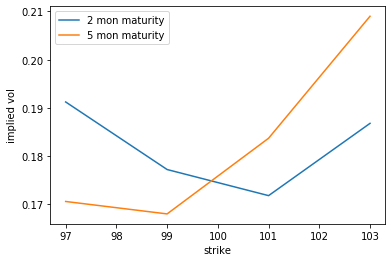

In [8]:
filter1 = np_option_data2[np_option_data2[:,1] == 2/12]
plt.plot(filter1[:,2], filter1[:,4], label = '2 mon maturity')
filter2 = np_option_data2[np_option_data2[:,1] == 5/12]
plt.plot(filter2[:,2], filter2[:,4], label = '5 mon maturity')
plt.ylabel('implied vol')
plt.xlabel('strike')
plt.legend();